In [1]:
!pip install numpy nltk gensim pandas bertopic sentence-transformers  wordcloud --no-deps

  Using cached gensim-4.3.3.tar.gz (23.3 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached bertopic-0.17.0-py3-none-any.whl.metadata (23 kB)
Using cached bertopic-0.17.0-py3-none-any.whl (150 kB)
Failed to build gensim


  error: subprocess-exited-with-error
  
  × Building wheel for gensim (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [779 lines of output]
      C:\Users\ruebe\AppData\Local\Temp\pip-build-env-17n7zp0x\overlay\Lib\site-packages\setuptools\_distutils\dist.py:289: UserWarning: Unknown distribution option: 'test_suite'
        warnings.warn(msg)
      C:\Users\ruebe\AppData\Local\Temp\pip-build-env-17n7zp0x\overlay\Lib\site-packages\setuptools\_distutils\dist.py:289: UserWarning: Unknown distribution option: 'tests_require'
        warnings.warn(msg)
      running bdist_wheel
      running build
      running build_py
      creating build\lib.win-amd64-cpython-313\gensim
      copying gensim\downloader.py -> build\lib.win-amd64-cpython-313\gensim
      copying gensim\interfaces.py -> build\lib.win-amd64-cpython-313\gensim
      copying gensim\matutils.py -> build\lib.win-amd64-cpython-313\gensim
      copying gensim\nosy.py -> build\lib.win-amd64-cpython-313\gensim
   

In [2]:
import pandas as pd
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer

# Load dataset
df = pd.read_csv('sample_data/podcast_transcriptions_chunked_sorted_numbered+english.csv')

# Verify columns
print("Available columns:", df.columns.tolist())
if 'Transcription' not in df.columns or 'Episode Number' not in df.columns:
    raise ValueError("Expected columns 'Transcription' and 'Episode Number' not found.")

# Prepare the transcription texts
docs = df['Transcription'].astype(str).tolist()
print("First episode:", df['Episode Number'].iloc[0])

# Create vectorizer without specifying stop_words
vectorizer_model = CountVectorizer()

# Initialize BERTopic with multilingual model and custom vectorizer
topic_model = BERTopic(
    embedding_model="paraphrase-multilingual-MiniLM-L12-v2",
    vectorizer_model=vectorizer_model
)

# Fit model
topics, probs = topic_model.fit_transform(docs)
#

ModuleNotFoundError: No module named 'bertopic'

In [ ]:
#save bertopic model
topic_model.save("sample_data/bertopic_model")

2025-06-16 09:26:41,851 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


In [ ]:
#load saved bert model
topic_model = BERTopic.load("sample_data/bertopic_model")

In [ ]:
df['topic'] = topics
df['topic_probability'] = probs
df[['Episode Number', 'topic', 'topic_probability']]


,Episode Number,topic,topic_probability
0,1,-1,0.000000
1,1,5,0.857568
2,1,0,0.783475
3,1,-1,0.000000
4,1,-1,0.000000
...,...,...,...
946,59,-1,0.000000
947,59,5,0.935414
948,59,10,1.000000
949,59,-1,0.000000


In [ ]:
# list every topic title
topic_titles = topic_model.get_topic_info()['Name'].tolist()
#save topics titles in a cvs
pd.DataFrame(topic_titles).to_csv("sample_data/bertopic_topic_titles_new.csv", index=False)
print(topic_titles)

['-1_ba_gore_go_le', '0_le_go_ka_ke', '1_gore_go_ke_ka', '2_go_gore_ga_ka', '3_ke_gore_ka_ba', '4_motswedinya_ke_ketshedimosetso_femo', '5_ba_le_gore_go', '6_bana_gore_go_mme', '7_go_ka_le_ba', '8_ba_go_ya_le', '9_go_gore_ya_ka', '10_ba_le_batho_go', '11_ka_go_gore_tsa', '12_gore_ka_go_di', '13_ka_ba_gore_ga']


In [ ]:
# save dataframe
df.to_csv("sample_data/bertopic_output_new.csv", index=False)

In [ ]:
df.shape

(951, 8)

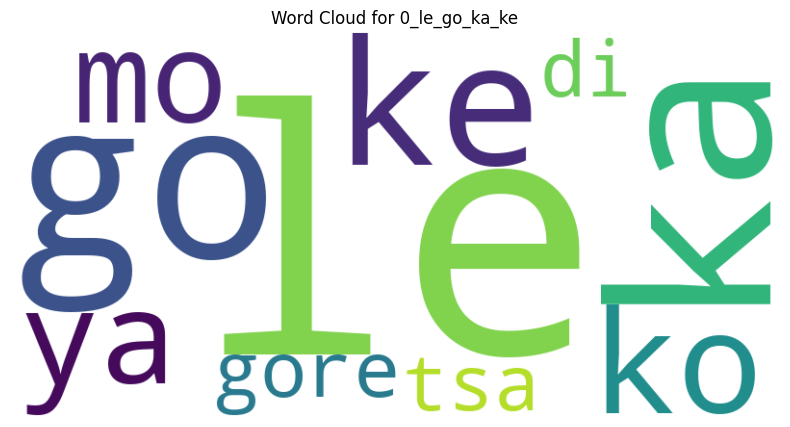

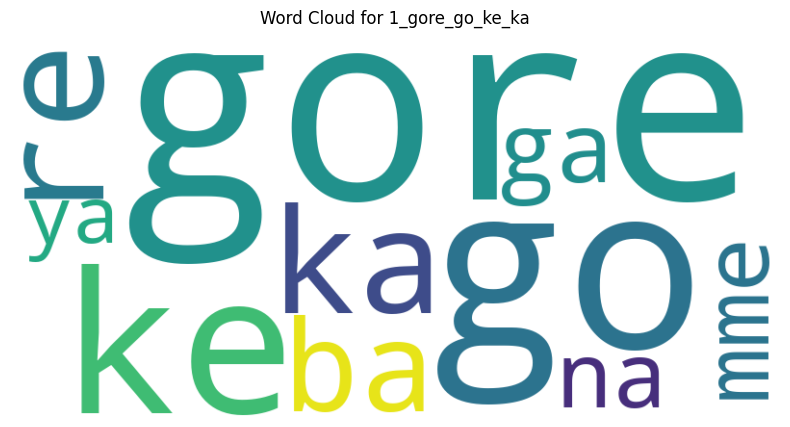

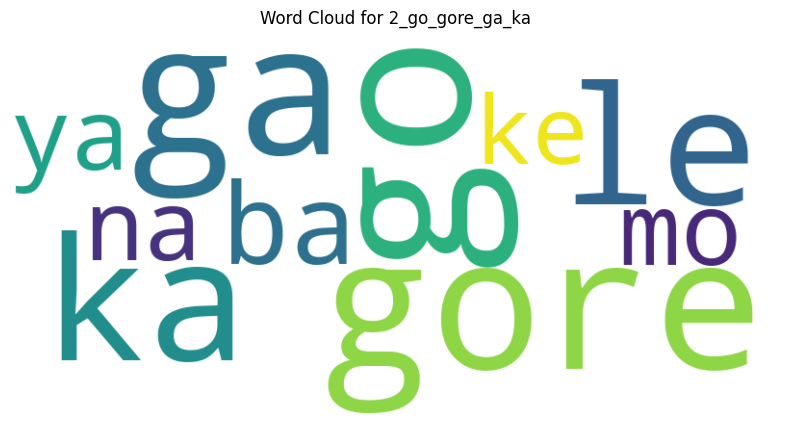

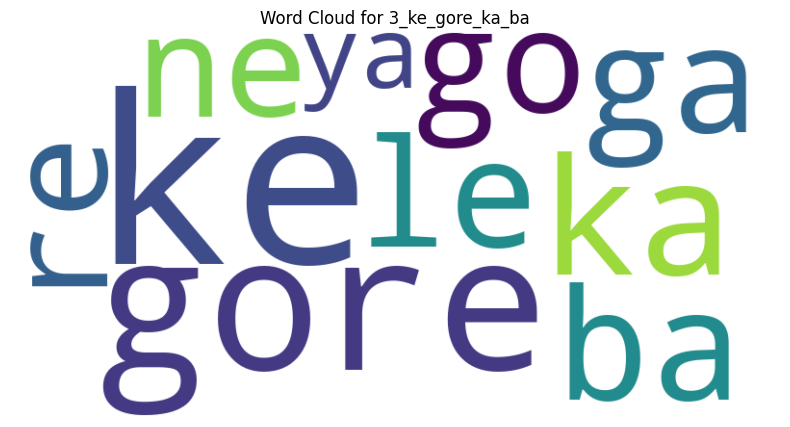

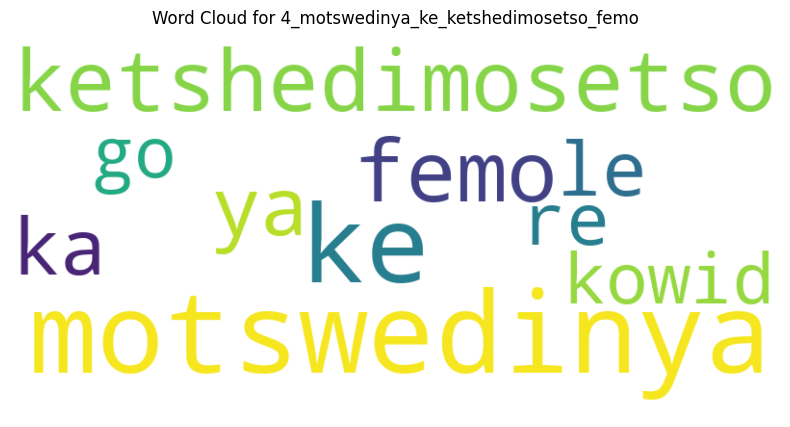

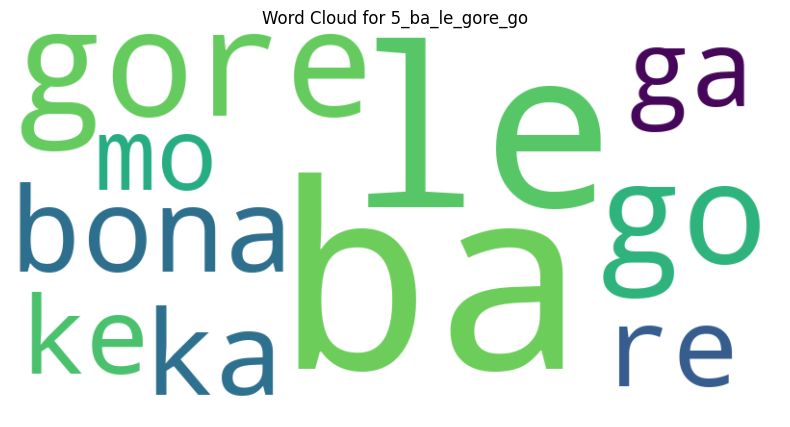

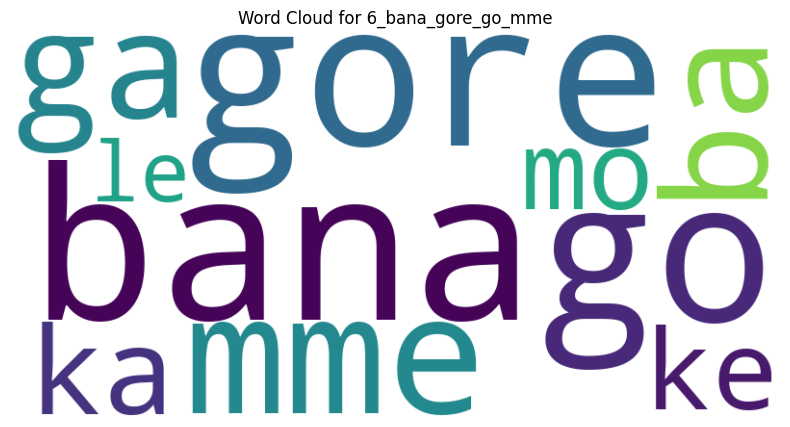

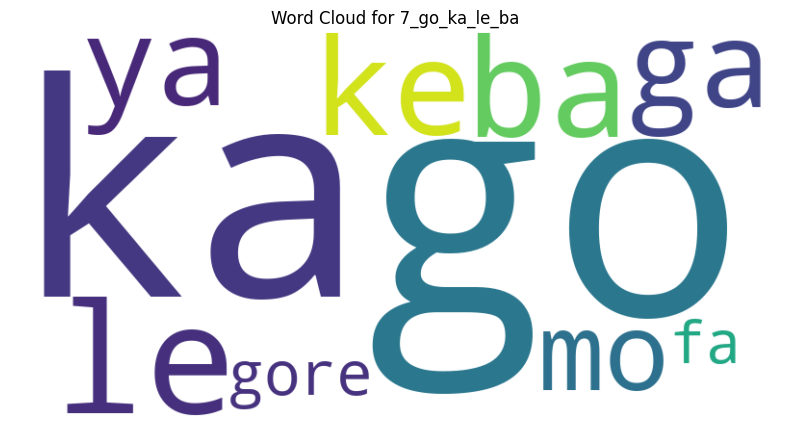

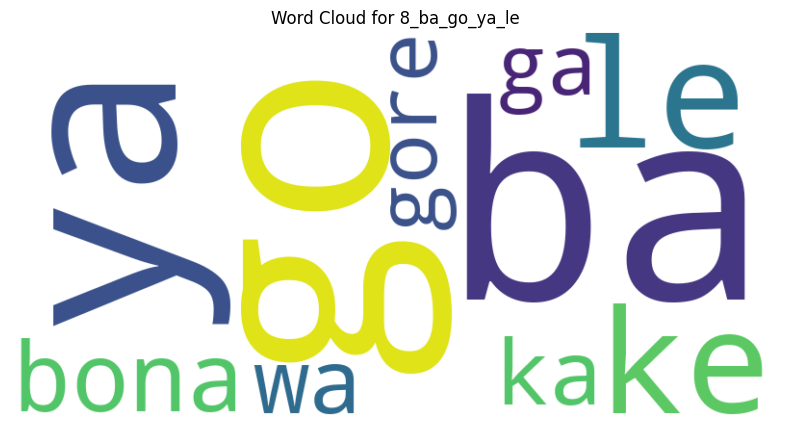

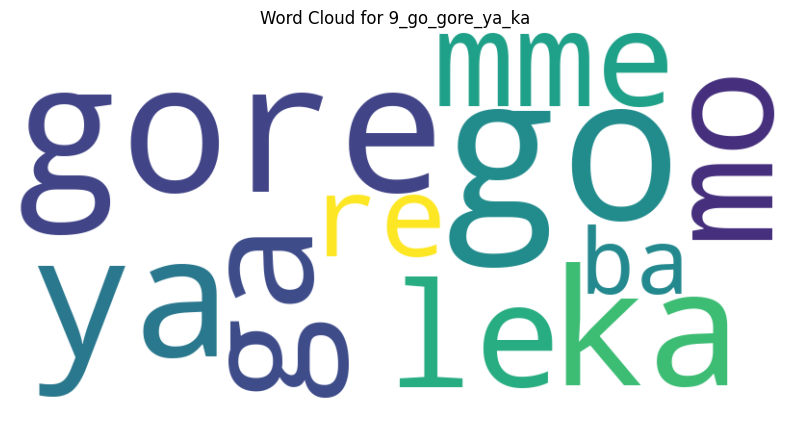

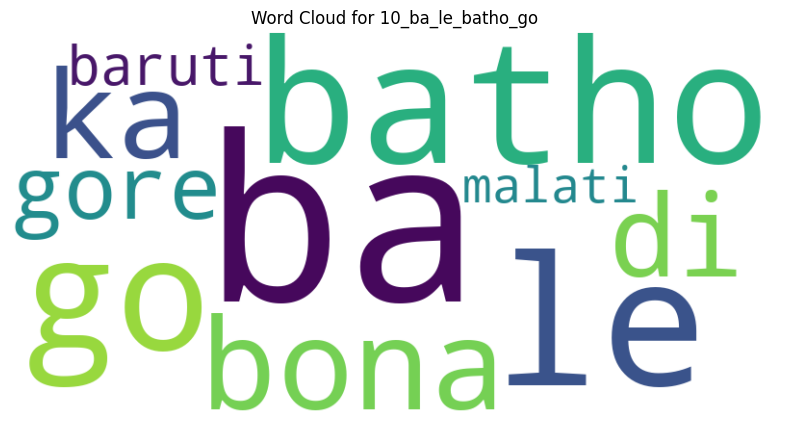

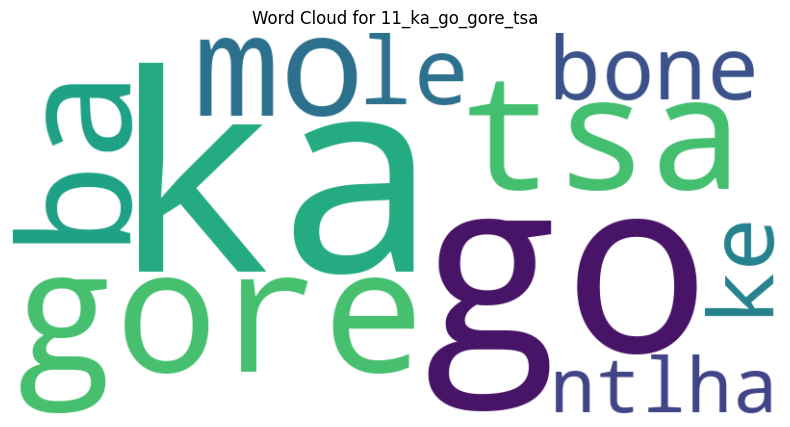

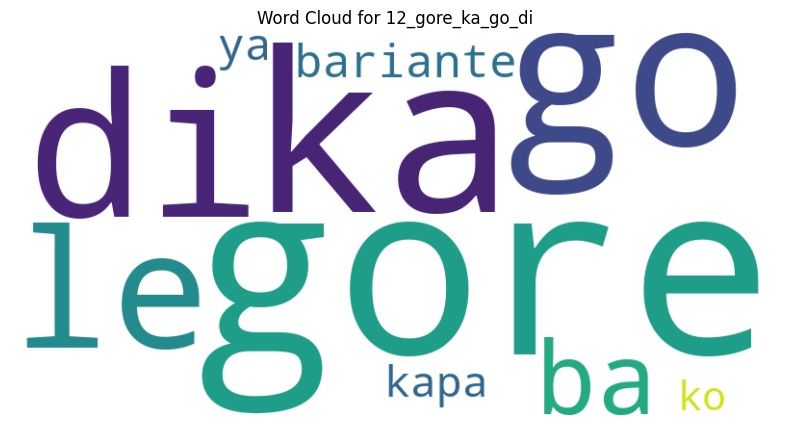

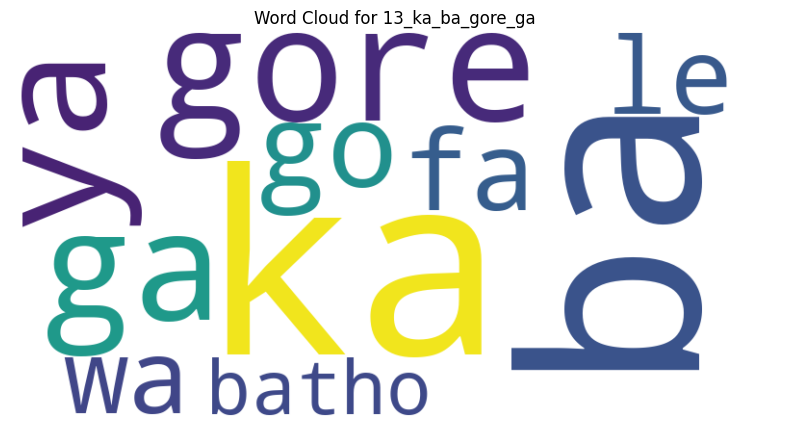

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Get detailed topic information
topic_info = topic_model.get_topic_info()
topic_freq = topic_model.get_topic_freq()

# Create a mapping from topic ID to topic name/label
topic_names = dict(zip(topic_freq['Topic'], topic_info['Name']))

# Generate word clouds for each topic (excluding -1, the outlier cluster)
for topic_id in topic_freq['Topic']:
    if topic_id == -1:
        continue  # Skip outliers

    # Get top words and their weights for this topic
    topic_words = topic_model.get_topic(topic_id)
    word_weights = {word: weight for word, weight in topic_words}

    # Create and display the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_weights)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for {topic_names.get(topic_id, f'Topic {topic_id}')}")
    plt.show()


In [ ]:
topic_model.get_topic_info()
topic_info.to_csv("sample_data/bertopic_topic_summary_new.csv", index=False)

In [ ]:
from gensim.corpora.dictionary import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize

# Tokenize Sesotho transcriptions
tokenized_docs = [word_tokenize(doc.lower()) for doc in docs]

# Build a dictionary and corpus for Gensim
dictionary = Dictionary(tokenized_docs)
corpus = [dictionary.doc2bow(text) for text in tokenized_docs]

# Extract BERTopic keywords only
bertopic_topics = topic_model.get_topics()
bertopic_words = [[word for word, _ in topic_model.get_topic(topic_id)] for topic_id in bertopic_topics if topic_id != -1]

# Coherence: UMass and NPMI
coherence_umass = CoherenceModel(topics=bertopic_words, texts=tokenized_docs, dictionary=dictionary, coherence='u_mass')
coherence_npmi = CoherenceModel(topics=bertopic_words, texts=tokenized_docs, dictionary=dictionary, coherence='c_npmi')

print("BERTopic Coherence (UMass):", coherence_umass.get_coherence())
print("BERTopic Coherence (NPMI):", coherence_npmi.get_coherence())


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


BERTopic Coherence (UMass): -0.9847167726146742
BERTopic Coherence (NPMI): -0.027028145846436955
